# Problem setting: Sine Wave Prediction.

This jupyter notebook demonstrates the function of **Attention Encoder/Decoder based on LSTM**.

In this demonstration, the training dataset is generated as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(ERROR)
logger.setLevel(ERROR)
logger.addHandler(handler)


In [3]:
def generate_sin(amp=0.5, sampling_freq=8000, freq=440, sec=5, extract_n=100):
    sin_list = []
    for n in np.arange(sampling_freq * sec):
        sin = amp * np.sin(2.0 * np.pi * freq * n / sampling_freq)
        sin_list.append(sin)
        if len(sin_list) > extract_n:
            break
    return np.array(sin_list[:extract_n])


In [4]:
generate_sin(freq=200).shape

(100,)

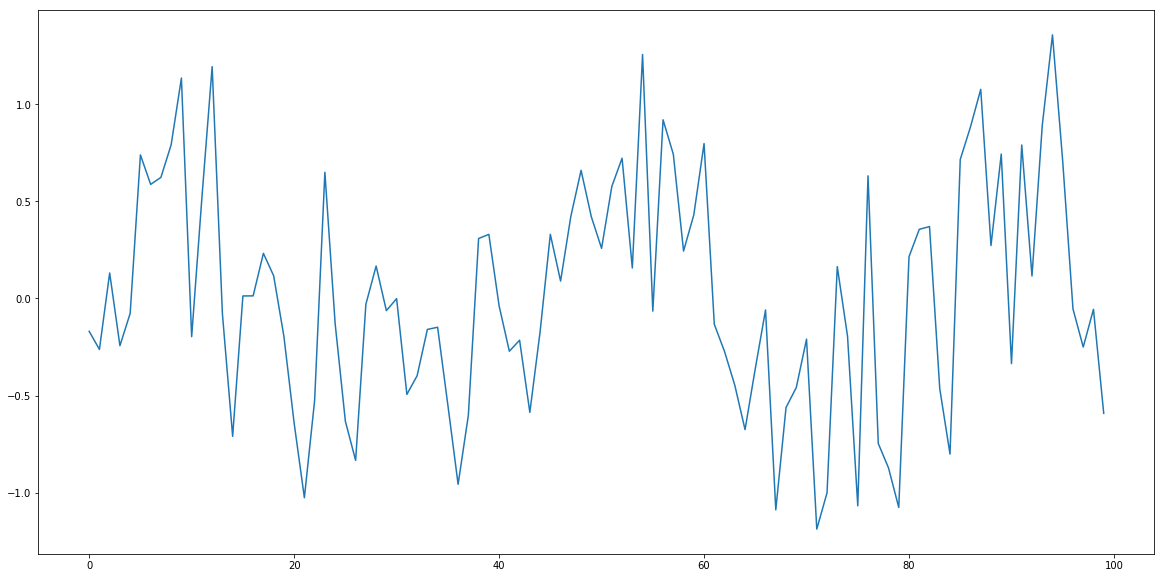

In [5]:
fig = plt.figure(figsize=(20, 10))
plt.plot(generate_sin(freq=200) + np.random.normal(loc=0.0, scale=0.5, size=100))
plt.show()

In [6]:
# The number of sampled data.
sample_n = 1000
# The length of one cycle.
cycle_len = 20
# The number of features.
feature_n = 20

# The list of observed data points.
observed_arr_list = []
# The list of objective data.
target_arr_list = []

label_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
test_size = 0.3

for i in range(sample_n):
    f_list = []
    t_list = []
    label_n = np.random.randint(low=0, high=len(label_list))

    for j in range(feature_n):
        sin_arr = generate_sin(freq=int(label_list[label_n]), extract_n=cycle_len)
        noise_arr = np.random.normal(loc=0.0, scale=1.5, size=cycle_len)
        sin_arr += noise_arr
        f_arr = sin_arr[:int(sin_arr.shape[0] * (1 - test_size))]
        t_arr = sin_arr[int(sin_arr.shape[0] * (1 - test_size)):]
        f_list.append(f_arr)
        t_list.append(t_arr)

    observed_arr_list.append(f_list)
    target_arr_list.append(t_list)

observed_arr = np.array(observed_arr_list)
observed_arr = (observed_arr - observed_arr.min()) / (observed_arr.max() - observed_arr.min())
observed_arr.shape

(1000, 20, 14)

All Sine waves have been added randomly generated gussain signal noise.

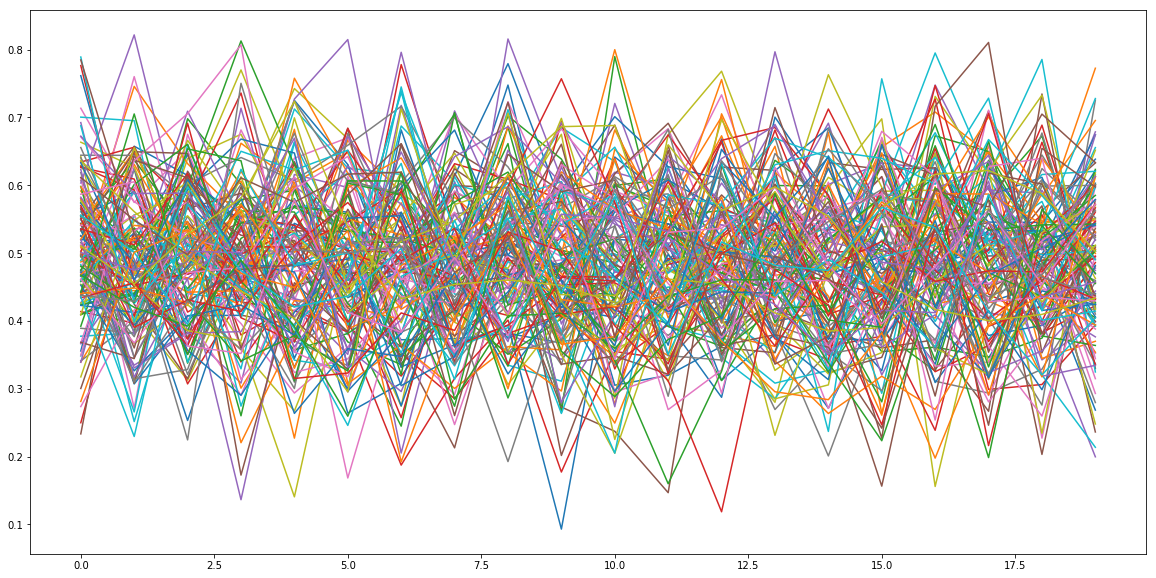

In [7]:
fig = plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(observed_arr[i])
plt.show();plt.close()

## Problem solution: Encoder/Decoder based on LSTM.

In [8]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Polymorphism.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstmgraph.attention_lstm_graph import AttentionLSTMGraph as DecoderGraph

# Loss function.
from pydbm.loss.mean_squared_error import MeanSquaredError
# SGD as a Loss function.
from pydbm.optimization.optparams.sgd import SGD
# Adam as a Loss function.
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
# Verification.
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Polymorphism.
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstmmodel.attention_lstm_model import AttentionLSTMModel as Decoder
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# Identity Function as activation function.
from pydbm.activation.identity_function import IdentityFunction
# Encoder/Decoder
from pydbm.rnn.encoder_decoder_controller import EncoderDecoderController

In [9]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=200,
    output_neuron_count=1
)

In [10]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = LogisticFunction()
decoder_graph.output_activating_function = LogisticFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=200,
    hidden_neuron_count=200,
    output_neuron_count=observed_arr.shape[-1]
)

In [11]:
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [12]:
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    seq_len=observed_arr.shape[1],
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [13]:
encoder_decoder_controller = EncoderDecoderController(
    encoder=encoder,
    decoder=decoder,
    epochs=300,
    batch_size=20,
    learning_rate=1e-08,
    learning_attenuate_rate=0.1,
    attenuate_epoch=50,
    test_size_rate=0.3,
    computable_loss=MeanSquaredError(),
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [17]:
# Learning.
encoder_decoder_controller.learn(observed_arr, observed_arr)

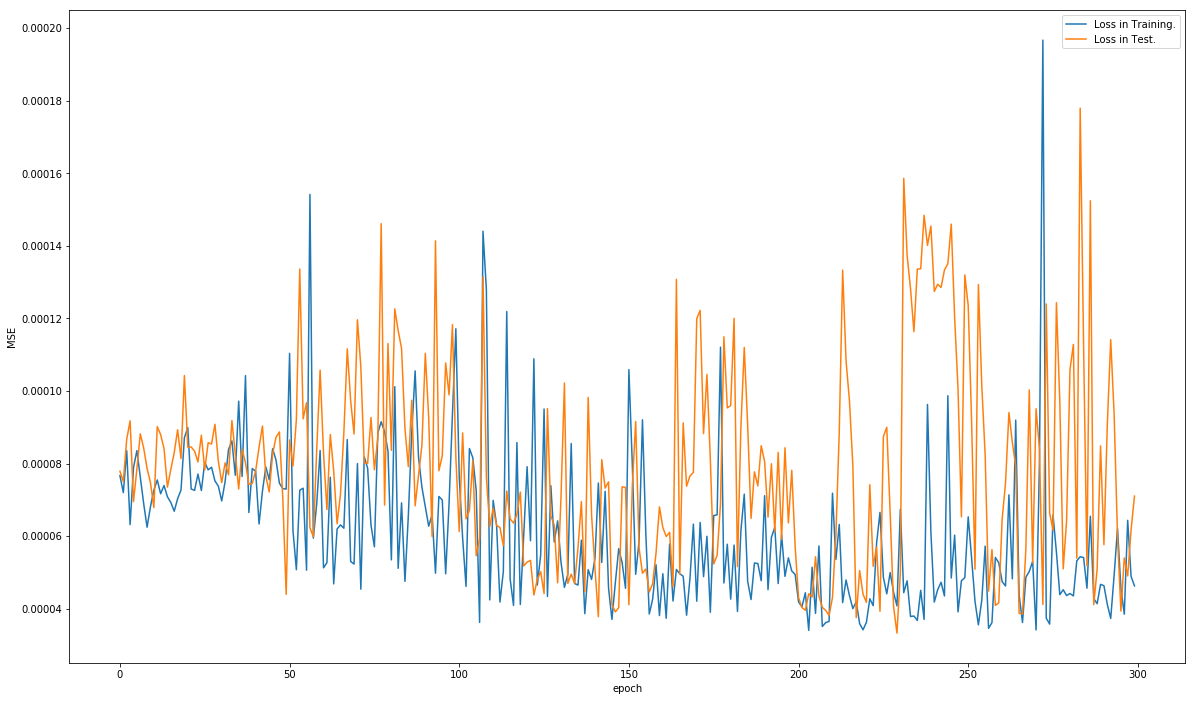

In [15]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [16]:
encoder_decoder_controller.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
290,0.000046,0.000058
291,0.000041,0.000091
292,0.000037,0.000114
293,0.000049,0.000094
294,0.000062,0.000060
295,0.000046,0.000039
296,0.000038,0.000054
297,0.000064,0.000049
298,0.000049,0.000062
299,0.000046,0.000071


# References

- Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in Neural Information Processing Systems (pp. 5998-6008).